# SyriaTel Customer Churn Project

### Team Members
    * Eddie Lin
    * Tony Bai
    * Douglas Lu
    * Arthur Kim

#sa

## Imports

In [1]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,log_loss, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE, SMOTENC

## Functions

In [2]:
def scores(actual, pred):
    print("log loss: ", log_loss(actual, pred))
    print("accuracy: ", accuracy_score(actual, pred))
    print("precision:", precision_score(actual, pred))
    print("recall:   ", recall_score(actual, pred))

## Data Manipulation

In [3]:
#load the data

df = pd.read_csv('data/syrialtel_cleaned_data.csv')

In [4]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_calls,total_charge,charge_per_min_day,charge_per_min_eve,charge_per_min_night,charge_per_min_dom,charge_per_min_int,%_int_min,call_satisfaction,region
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,303,75.56,0.409727,0.169495,0.120989,0.242867,0.900000,1.394311,0.330033,Midwest
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,332,59.24,0.223333,0.161359,0.111165,0.168815,1.233333,2.191299,0.301205,Midwest
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,333,62.29,0.362982,0.093636,0.070385,0.179878,0.658000,2.261772,0.000000,Northeast
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,255,66.80,0.716901,0.059773,0.099551,0.262177,0.254286,1.168555,0.784314,Midwest
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,359,52.09,0.250796,0.103361,0.069504,0.138652,0.910000,1.972656,0.835655,South


The data is split to a train and test data

In [5]:
#seperating the target and data
X = df.drop('churn', axis=1)
y = df['churn']

#creating a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Splitting the data between categorical and continuous

In [6]:
categorical = ['state','area_code', 'international_plan', 'voice_mail_plan', 'region']
df_cat = X_train[categorical]
df_cont = X_train.drop(categorical,axis = 1)

In [7]:
#splitting the numericals and categoricals
X_num = df_cont.columns
X_cat = df_cat.columns

## Pipeline

In [8]:
#preprocessing the pipeline with standard scaler and one hot encoder
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

In [9]:
# transform the pipeline and then converting it back into a dataframe
X_train_scaled = pp.fit_transform(X_train)
X_test_scaled = pp.transform(X_test)

In [10]:
# aggregating col names from the one hot encode 
cat_names = pp.transformers_[1][1].named_steps['ohe'].get_feature_names(X_cat).tolist()
feature_names= list(X_num) + cat_names

# renaming the data frame with corresponding col names
X_train_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [11]:
##DUMMY insert
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)

y_preds_dum= dummy_clf.predict(X_test)

scores(y_test, y_preds_dum)

log loss:  4.939045024472227
accuracy:  0.857
precision: 0.0
recall:    0.0


/Users/arthur/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 1:  Log Regression

In [13]:
## used a baseline log regression model to test out the data


logreg_baseline = LogisticRegression(random_state=42, max_iter=2000)#look into warning

logreg_baseline.fit(X_train_scaled, y_train)

logreg_baseline_cv = cross_val_score(logreg_baseline, X_train_scaled, y_train).mean()
print(logreg_baseline_cv)

0.8636884138552169


In [14]:
print(logreg_baseline.score(X_train_scaled, y_train))
print(logreg_baseline.score(X_test_scaled, y_test))

0.8769824260608658
0.867


In [168]:
y_preds_log = logreg_baseline.predict(X_test_scaled)
scores(y_test, y_preds_log)

log loss:  4.593675651264016
accuracy:  0.867
precision: 0.5892857142857143
recall:    0.23076923076923078


### Not terrible results for the first model

#### But we have decided to look at recall for our metric. As a telecom company trying to reduce churn, we care about the recall of our model. Recall is defined as the TP/(TP+FN). We are trying to minimize False Negatives (FN) here, meaning that we want to reduce the number of people that our model predicts will churn but are not actually likely to. This is because we want to send out promotions to retain customers and we do not want to offer discounts to people that were already satisfied

## Model 2: K-Nearest Neighbors and Grid Search without SMOTE

In [302]:

### initate the model with no parameters

knn_model = KNeighborsClassifier()


# initiate grid and grid search
param_grid = {
    'n_neighbors': list(range(1, 20, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4],
}


gs_knn = GridSearchCV(knn_model, param_grid=param_grid, cv=5)
gs_knn.fit(X_train_scaled, y_train)

gs_knn.best_params_

{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

In [16]:
gs_knn.score(X_train_scaled, y_train)

0.9074153450492928

In [17]:
gs_knn.score(X_test_scaled, y_test)

0.901

In [19]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1993
           1       0.94      0.39      0.55       340

    accuracy                           0.91      2333
   macro avg       0.92      0.69      0.75      2333
weighted avg       0.91      0.91      0.89      2333



In [20]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       857
           1       0.96      0.32      0.48       143

    accuracy                           0.90      1000
   macro avg       0.93      0.66      0.71      1000
weighted avg       0.91      0.90      0.88      1000



In [21]:
print(confusion_matrix(y_train, y_train_preds))

[[1985    8]
 [ 208  132]]


In [22]:
print(confusion_matrix(y_test, y_test_preds))

[[855   2]
 [ 97  46]]


Our recall score came out too low and maybe this was caused because of a class imbalance. Now we will try to use SMOTE to reduce that

## Model 3: K-Nearest Neighbors and Grid Search with SMOTE

In [304]:
# calculate the current ratio of imbalance for SMOTE 
round(len(y_train[y_train==1])/len(y_train[y_train==0]),2)

0.17

In [305]:
# SMOTE the categorical columns by their index
smote = SMOTENC([28, 29, 30, 31, 32, 33, 34],random_state=42, sampling_strategy=0.5)
# X_train_resampled, y_train_resampled = smote.fit_sample(X_train_scaled, y_train)

In [345]:

# Rerun the KNN Model with SMOTED DATA

knn_model_smote = imbpipeline(steps=[
        ("Preprocess", pp),
        ('sampling', smote),
        ('knn', KNeighborsClassifier())
    ])

#perform a grid search again to see if criteria changed
param_grid = {
    'n_neighbors': list(range(80, 100, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4],
}

gs_knn = GridSearchCV(knn_model_smote, param_grid, cv=5, scoring='recall')
# gs_knn.fit(X_train_resampled, y_train_resampled)

# gs_knn.best_params_

In [346]:
gs_knn.fit(X_train, y_train)

# gs_knn.best_params_

ValueError: Invalid parameter weights for estimator Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_int...
       'charge_per_min_int', '%_int_min', 'call_satisfaction'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['state', 'area_code', 'international_plan', 'voice_mail_plan',
       'region'],
      dtype='object'))])),
                ('sampling',
                 SMOTENC(categorical_features=[28, 29, 30, 31, 32, 33, 34],
                         random_state=42, sampling_strategy=0.5)),
                ('knn', KNeighborsClassifier())]). Check the list of available parameters with `estimator.get_params().keys()`.

In [307]:
gs_knn.score(X_train_scaled, y_train)

1.0

In [308]:
gs_knn.score(X_test_scaled, y_test)

0.7062937062937062

In [309]:
y_train_preds = gs_knn.predict(X_train_scaled)
y_test_preds = gs_knn.predict(X_test_scaled)

In [310]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1993
           1       1.00      1.00      1.00       340

    accuracy                           1.00      2333
   macro avg       1.00      1.00      1.00      2333
weighted avg       1.00      1.00      1.00      2333



In [311]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       857
           1       0.73      0.71      0.72       143

    accuracy                           0.92      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.92      0.92      0.92      1000



In [32]:
print(confusion_matrix(y_test, y_test_preds))

[[722 135]
 [ 61  82]]


## Decision Tree Model

In [73]:
#Instantiate a Decision Tree and perform 3-fold cross-validaiton on training data

DT_clf = DecisionTreeClassifier() 

DT_cv_score = cross_val_score(DT_clf, X_train_scaled, y_train, cv=3)

mean_DT_cv_score = np.mean(DT_cv_score)

print(f"Mean Cross Val Score: {mean_DT_cv_score:.2%}")

#Model did extremly well, perhaps a bit too well. We should take a look for any imbalances. 

Mean Cross Val Score: 94.56%


In [ ]:
#Create grid search parameters and intantiate GridSearch CV. Create different parameters and then fit the data. 

# DT_clf = DecisionTreeClassifier() 

# param_grid = { 
#     'criterion': ['gini', 'entropy'],
#     'max_depth': np.arange(1, 15, 2), #step up even higher 
#     'min_samples_split': np.arange(5, 120, 5),
#     'min_samples_leaf': np.arange(5, 120,5)
#     }

# gs_DT_clf = GridSearchCV(DT_clf, param_grid = param_grid, n_jobs = -1, scoring = "recall", cv = 5)

# gs_DT_clf.fit(X_train_scaled, y_train)
    
#SPECIFCY SCORING IN GRIDSEARCH TO RECALL? CURRENTLY ON ACCURACY: scoring = 'recall',  

#consistency in paramgrid search rationale 
#random CV search 

#After running it best parameter = 
# {'criterion': 'entropy',
#  'max_depth': 5,
#  'min_samples_leaf': 10,
#  'min_samples_split': 3}

In [77]:
best_DT_clf = DecisionTreeClassifier(criterion='entropy',
                                    max_depth= 5,
                                    min_samples_leaf= 10,
                                    min_samples_split= 3) 
best_DT_clf.fit(X_train_scaled, y_train)

y_train_preds = best_DT_clf.predict(X_train_scaled)
y_test_preds = best_DT_clf.predict(X_test_scaled)


In [78]:
print(classification_report(y_train, y_train_preds))
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1993
           1       1.00      0.81      0.90       340

    accuracy                           0.97      2333
   macro avg       0.98      0.91      0.94      2333
weighted avg       0.97      0.97      0.97      2333

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       857
           1       1.00      0.87      0.93       143

    accuracy                           0.98      1000
   macro avg       0.99      0.93      0.96      1000
weighted avg       0.98      0.98      0.98      1000

[[857   0]
 [ 19 124]]


In [79]:
best_DT_clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00637507,
       0.        , 0.0616826 , 0.        , 0.        , 0.1521506 ,
       0.        , 0.00577382, 0.        , 0.        , 0.        ,
       0.4187382 , 0.        , 0.        , 0.        , 0.        ,
       0.07633658, 0.        , 0.00295954, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

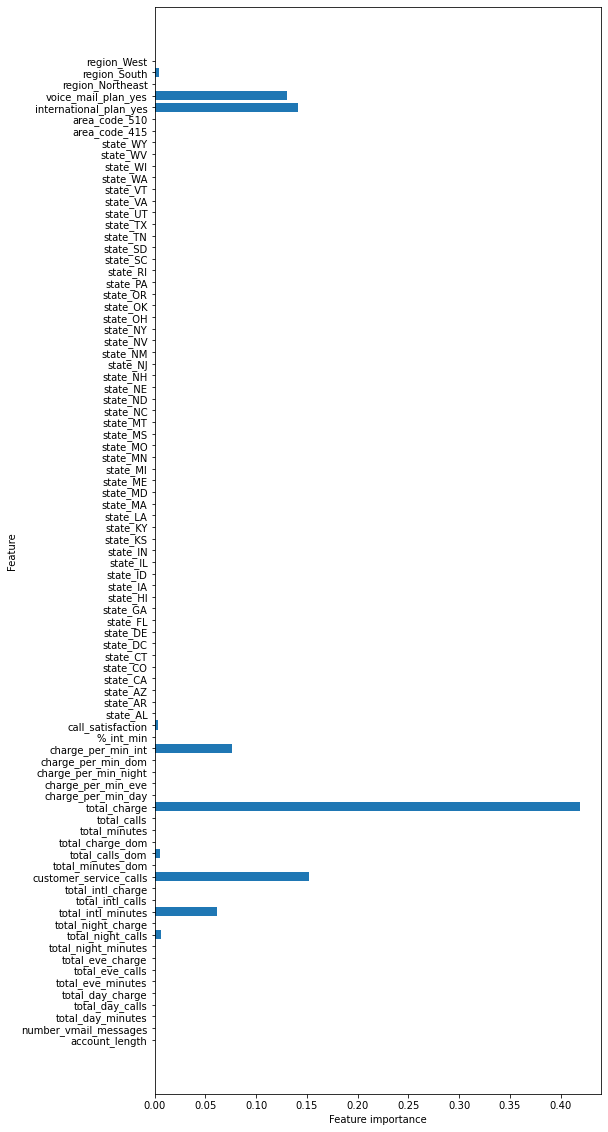

In [84]:
def plot_feature_importances(model):
    n_features = X_train_scaled.shape[1]
    plt.figure(figsize=(8,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_scaled.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(best_DT_clf)

# Bagging Model

In [87]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', 
                                                       max_depth = 5, 
                                                       min_samples_leaf = 10, 
                                                       min_samples_split = 3), 
                                                       n_estimators = 20)

#Fit the model on training data
bagged_tree.fit(X_train_scaled, y_train)
#Training accuracy score 
bagged_tree.score(X_train_scaled, y_train)
#Test accuracy score
bagged_tree.score(X_test_scaled, y_test)

#make comment about overfit and why

0.981

# Random Forest

In [89]:
rf_model = RandomForestClassifier(criterion = 'entropy', 
                                  n_estimators = 1150, 
                                  max_depth=10, 
                                  bootstrap = True, 
                                  min_samples_split= 7)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=7,
                       n_estimators=1150)

In [95]:
rf_preds = rf_model.predict(X_test_scaled)
scores(y_test, rf_preds)

log loss:  1.3470122794015174
accuracy:  0.961
precision: 1.0
recall:    0.7272727272727273


In [97]:
# Grid Search for parameters, Played around with n_estimators before and found the optimal so excluded from this grid search
grid = {        
 'max_depth': [8,10],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 7]}

gs = GridSearchCV(estimator=rf_model, param_grid= grid, cv=2)
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=10,
                                              min_samples_split=7,
                                              n_estimators=1150),
             param_grid={'max_depth': [8, 10], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7]})

In [109]:
gs.best_params_
best_model= gs.best_estimator_
best_param=[]
for name, score in zip(X_train_scaled.columns, rf_model.feature_importances_):
    
    best_param.append((name,score))
best_param.sort(reverse= True, key=lambda x: x[1])
best_param[:10]

[('total_charge', 0.11603463923585035),
 ('total_charge_dom', 0.09165626921773305),
 ('customer_service_calls', 0.07603171274692963),
 ('call_satisfaction', 0.07278358632885197),
 ('international_plan_yes', 0.07258065463225186),
 ('total_day_minutes', 0.04704655008951919),
 ('total_day_charge', 0.043676277803954125),
 ('total_minutes', 0.03955641304780503),
 ('total_minutes_dom', 0.037589999038284985),
 ('number_vmail_messages', 0.029933485522696014)]

# XGBoost

In [49]:
xgb_model= xg.XGBClassifier(random_state=42, objective='binary:logistic')

In [50]:
grid2 = {'eta': [.05,.1, .2, .4],
         'max_depth': [3,8,9],
         'alpha' : [1,2,3,4]
 }
gs = GridSearchCV(estimator=xgb_model, param_grid= grid2, cv=2)

In [51]:
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [52]:
gs.best_params_

{'alpha': 2, 'eta': 0.2, 'max_depth': 3}

In [53]:
xgb_model2= xg.XGBClassifier(random_state=42, objective='binary:logistic', alpha=2, eta=0.2, max_depth=3)

In [54]:
best_param = []
fit = xgb_model2.fit(X_train_scaled, y_train)
for name, score in zip(X_train_scaled.columns, fit.feature_importances_):
    
    best_param.append((name,score))
best_param.sort(reverse= True, key=lambda x: x[1])
best_param

[('total_charge', 0.2064817),
 ('customer_service_calls', 0.15857959),
 ('number_vmail_messages', 0.1379397),
 ('international_plan_yes', 0.081443824),
 ('total_intl_calls', 0.07584284),
 ('total_intl_minutes', 0.04833098),
 ('charge_per_min_int', 0.04502448),
 ('total_calls', 0.02036409),
 ('area_code_415', 0.017601628),
 ('call_satisfaction', 0.015248079),
 ('total_minutes', 0.013633176),
 ('total_eve_minutes', 0.013495498),
 ('region_South', 0.013340767),
 ('%_int_min', 0.013316962),
 ('charge_per_min_dom', 0.011165017),
 ('region_Northeast', 0.010999993),
 ('total_night_calls', 0.010710389),
 ('charge_per_min_night', 0.010427377),
 ('total_day_calls', 0.010196842),
 ('charge_per_min_eve', 0.009820581),
 ('total_charge_dom', 0.009337022),
 ('area_code_510', 0.00914245),
 ('total_minutes_dom', 0.008669826),
 ('account_length', 0.008285145),
 ('total_day_minutes', 0.008019949),
 ('charge_per_min_day', 0.00793765),
 ('total_calls_dom', 0.007877018),
 ('total_eve_calls', 0.006637635),
 

In [19]:
xgb_model.fit(X_train_scaled, y_train)
y_preds_xgb = xgb_model.predict(X_test_scaled)
scores(y_test, y_preds_xgb)

log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


# AdaBoost

In [130]:
model_boost_ada = AdaBoostClassifier(n_estimators=40,random_state=42)
model_boost_ada.fit(X_train_scaled,y_train)
model_boost_ada.predict(X_train_scaled)

model_boost_ada.score(X_train_scaled,y_train)


0.9262751821688813

In [128]:
y_preds= model_boost_ada.predict(X_test_scaled)
scores(y_test, y_preds)

log loss:  3.1430478422751973
accuracy:  0.909
precision: 0.76
recall:    0.5314685314685315


# Gradient Boost

In [129]:
model_boost_gb = GradientBoostingClassifier(random_state=42)
gb_m = model_boost_gb.fit(X_train_scaled,y_train)
model_boost_gb.score(X_train_scaled,y_train)

0.9819974282040291

In [131]:
y_preds= model_boost_gb.predict(X_test_scaled)
scores(y_test, y_preds)

log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


In [132]:
gradient_boost_cv = cross_val_score(gb_m, X_train_scaled, y_train, cv = 10)
gradient_boost_cv
gradient_boost_cv.mean()

0.9772862330802244

# Ensemble

In [195]:
voting_clf = VotingClassifier(estimators=[ 
                                          ("rf", rf_model) ,
                                          ('dt', best_DT_clf),
                                          ('xgb', xgb_model),
                                          ("gb", gb_m)], 
                                          voting= "soft")

In [196]:
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=10,
                                                     min_samples_split=7,
                                                     n_estimators=1150)),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     min_samples_leaf=10,
                                                     min_samples_split=3)),
                             ('xgb',
                              XGBClassifier(alpha=1, base_score=0.5,
                                            booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsampl

In [197]:
y_preds = voting_clf.predict(X_test_scaled)

In [198]:
scores(y_test, y_preds)

log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


In [199]:
for clf in (rf_model, best_DT_clf, xgb_model, gb_m):
    clf.fit(X_train_scaled, y_train)
    y_pred= clf.predict(X_test_scaled)
    print(clf, recall_score(y_test, y_pred))

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=7,
                       n_estimators=1150) 0.7202797202797203
DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       min_samples_split=3) 0.8671328671328671
XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:hinge', random_state=42, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 0.8881118881118881
GradientBoostingClassifier(random_state=42) 0.88811188

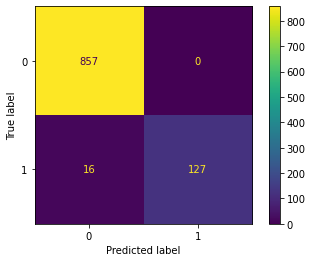

In [200]:
plot_confusion_matrix(voting_clf, X_test_scaled, y_test)

Looks like the ensemble does the same however if we introduce unseen data having a ensemble may be to our advantage

# Let's create a function to calculate percentage of a customer churning

In [217]:
df.columns[:2]

Index(['state', 'account_length'], dtype='object')

In [282]:
# single customer churning probability calculator

def churn(total_day_minutes, total_charge, customer_service_calls, international_plan):
    
    #using the ensemble to predict
    voting_clf = VotingClassifier(estimators=[ 
                                          ("rf", rf_model) ,
                                          ('dt', best_DT_clf),
                                          ('xgb', xgb_model),
                                          ("gb", gb_m)], 
                                          voting= "soft")
    
    #slice out corresponding df
    data= df[['total_day_minutes', 'total_charge', 
            'customer_service_calls','international_plan','churn'
              ]]
    
    
    #split into train test
    y= data['churn']
    X= data.drop('churn', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3 ,random_state=42)
    
    
    #pipeline reintroduced to fit specific data frame
    
    X_num=X_train.columns[:3]
    X_cat=X_train.columns[3:4]
    
    numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
    catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

    pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])
    
    
    #use pipeline to scale 
    X_train_scaled = pp.fit_transform(X_train)
    X_test_scaled= pp.transform(X_test)
    X_train_scaled= pd.DataFrame(X_train_scaled)
    X_test_scaled=pd.DataFrame(X_test_scaled)
    
#     create a single entry from function inputs to test
    d= {'total_day_minutes':total_day_minutes , 
        'total_charge': total_charge , 
        'customer_service_calls': customer_service_calls,
        'international_plan':international_plan}
    
    df_pred= pd.DataFrame(d, index=[0])
    
    #scale it so model doesnt break on string entries
    df_pred = pp.transform(df_pred)
    df_pred = pd.DataFrame(df_pred)
    
    #fit the model
    voting_clf.fit(X_train_scaled, y_train)
  
    #predict the probability that customer may churn
    p = voting_clf.predict_proba(df_pred)[0][1]
    
    if p >.5:
        return 1
    else:
        return 0
    
#     print(f"The selected account has a {round(p[0][1]*100)}% chance of churning ")
    

In [283]:
churn(200,34,0,"yes")

0

In [239]:
# example used for one customer
churn(128,75.56,1,"no")

The selected account has a 84.0% chance of churning 


In [251]:
df.loc[193]

state                            MT
account_length                   94
area_code                       415
international_plan               no
voice_mail_plan                  no
number_vmail_messages             0
total_day_minutes             137.5
total_day_calls                 118
total_day_charge              23.38
total_eve_minutes             203.2
total_eve_calls                  88
total_eve_charge              17.27
total_night_minutes             150
total_night_calls               131
total_night_charge             6.75
total_intl_minutes             13.4
total_intl_calls                  2
total_intl_charge              3.62
customer_service_calls            0
churn                             0
total_minutes_dom             490.7
total_calls_dom                 337
total_charge_dom               47.4
total_minutes                 504.1
total_calls                     339
total_charge                  51.02
charge_per_min_day         0.198136
charge_per_min_eve          

In [252]:
churn(94,51.02,0,"no")

The selected account has a 2.0% chance of churning 


In [258]:
df.head(20)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_calls,total_charge,charge_per_min_day,charge_per_min_eve,charge_per_min_night,charge_per_min_dom,charge_per_min_int,%_int_min,call_satisfaction,region
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,303,75.56,0.409727,0.169495,0.120989,0.242867,0.900000,1.394311,0.330033,Midwest
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,332,59.24,0.223333,0.161359,0.111165,0.168815,1.233333,2.191299,0.301205,Midwest
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,333,62.29,0.362982,0.093636,0.070385,0.179878,0.658000,2.261772,0.000000,Northeast
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,255,66.80,0.716901,0.059773,0.099551,0.262177,0.254286,1.168555,0.784314,Midwest
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,359,52.09,0.250796,0.103361,0.069504,0.138652,0.910000,1.972656,0.835655,South
5,AL,118,510,yes,no,0,223.4,98,37.98,220.6,...,323,67.61,0.387551,0.185644,0.077797,0.207918,0.283333,0.963008,0.000000,South
6,MA,121,510,no,yes,24,218.2,88,37.09,348.5,...,321,78.31,0.421477,0.274259,0.081102,0.242930,0.290000,0.953228,0.934579,Northeast
7,MO,147,415,yes,no,0,157.0,79,26.69,103.1,...,275,46.90,0.337848,0.093191,0.099271,0.167212,0.320000,1.482255,0.000000,Midwest
8,LA,117,408,no,no,0,184.5,97,31.37,351.6,...,271,73.32,0.323402,0.373625,0.107889,0.265805,0.587500,1.143834,0.369004,South
9,WV,141,415,yes,yes,37,258.6,84,43.96,222.0,...,297,80.54,0.523333,0.170000,0.151443,0.265479,0.604000,1.368858,0.000000,South


In [265]:
df2= df.head(20)

In [266]:
df2

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_calls,total_charge,charge_per_min_day,charge_per_min_eve,charge_per_min_night,charge_per_min_dom,charge_per_min_int,%_int_min,call_satisfaction,region
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,303,75.56,0.409727,0.169495,0.120989,0.242867,0.900000,1.394311,0.330033,Midwest
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,332,59.24,0.223333,0.161359,0.111165,0.168815,1.233333,2.191299,0.301205,Midwest
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,333,62.29,0.362982,0.093636,0.070385,0.179878,0.658000,2.261772,0.000000,Northeast
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,255,66.80,0.716901,0.059773,0.099551,0.262177,0.254286,1.168555,0.784314,Midwest
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,359,52.09,0.250796,0.103361,0.069504,0.138652,0.910000,1.972656,0.835655,South
5,AL,118,510,yes,no,0,223.4,98,37.98,220.6,...,323,67.61,0.387551,0.185644,0.077797,0.207918,0.283333,0.963008,0.000000,South
6,MA,121,510,no,yes,24,218.2,88,37.09,348.5,...,321,78.31,0.421477,0.274259,0.081102,0.242930,0.290000,0.953228,0.934579,Northeast
7,MO,147,415,yes,no,0,157.0,79,26.69,103.1,...,275,46.90,0.337848,0.093191,0.099271,0.167212,0.320000,1.482255,0.000000,Midwest
8,LA,117,408,no,no,0,184.5,97,31.37,351.6,...,271,73.32,0.323402,0.373625,0.107889,0.265805,0.587500,1.143834,0.369004,South
9,WV,141,415,yes,yes,37,258.6,84,43.96,222.0,...,297,80.54,0.523333,0.170000,0.151443,0.265479,0.604000,1.368858,0.000000,South


In [285]:
a=[]
for index, i in df2.iterrows():
    result = churn(i['account_length'], i['total_charge'], i['customer_service_calls'], i['international_plan'])
    a.append(result)
#     print(i)

In [286]:
a

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [287]:
b= df.loc[:19, "churn"]==a

In [288]:
b

0     False
1      True
2      True
3      True
4      True
5      True
6     False
7      True
8      True
9     False
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
Name: churn, dtype: bool

In [291]:
df.loc[(df['churn']==1),"total_charge"].avg()

AttributeError: 'Series' object has no attribute 'avg'

In [ ]:
df.loc[(df['churn']==1),"total_charge"]